In [ ]:
from google.colab import auth
from datetime import datetime
import os
import numpy as np
import pandas as pd
from google.colab import drive
import torch
import torchaudio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import special
import zipfile
import requests
from io import BytesIO

!git clone https://github.com/PK1725/ssast_custom.git
!wget https://www.dropbox.com/s/ewrzpco95n9jdz6/SSAST-Base-Patch-400.pth?dl=1 -O SSAST-Base-Patch-400.pth

!pip install timm=="0.4.5"
from ssast_custom.src.models import ASTModel

# Import .wav file from Google Drive
from google.colab import drive
drive.mount('/content/drive')
wav_path = '/content/drive/MyDrive/Colab Notebooks/data/xAI_audio/sang3.wav'



Cloning into 'ssast_custom'...
remote: Enumerating objects: 568, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 568 (delta 0), reused 0 (delta 0), pack-reused 563
Receiving objects: 100% (568/568), 11.99 MiB | 10.26 MiB/s, done.
Resolving deltas: 100% (331/331), done.
--2023-12-20 10:33:47--  https://www.dropbox.com/s/ewrzpco95n9jdz6/SSAST-Base-Patch-400.pth?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/ewrzpco95n9jdz6/SSAST-Base-Patch-400.pth [following]
--2023-12-20 10:33:48--  https://www.dropbox.com/s/dl/ewrzpco95n9jdz6/SSAST-Base-Patch-400.pth
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce47587377b90121664c278a701.dl.dropboxusercontent.com/cd/0/get/C

In [ ]:

# Create a new folder
drum_path = "drums"  # Adjust the path as needed
violin_path = "violins"  # Adjust the path as needed

# Create the folder if it doesn't exist
if not os.path.exists(drum_path):
    os.makedirs(drum_path)
# Create the folder if it doesn't exist
if not os.path.exists(violin_path):
    os.makedirs(violin_path)

# Your modified Dropbox link
url_drum = 'https://www.dropbox.com/scl/fo/3r6y5rukigkeojz6rz3t8/h?rlkey=t8tkj85lepfql5vbjisq7a18n&dl=1'  # Replace with your modified link
url_violin = 'https://www.dropbox.com/scl/fo/3zmoanvnhskd0st2zrqtz/h?rlkey=fkya4kg6ztos6akb5t8dbcheb&dl=1'  # Replace with your modified link

# Send a request to the URL
response = requests.get(url_drum)

# Open the response content in bytes, then extract and save it in the new folder
with zipfile.ZipFile(BytesIO(response.content)) as zip_ref:
    zip_ref.extractall(drum_path)

# Send a request to the URL
response = requests.get(url_violin)
# Open the response content in bytes, then extract and save it in the new folder
with zipfile.ZipFile(BytesIO(response.content)) as zip_ref:
    zip_ref.extractall(violin_path)

print("Download and extraction complete!")

Download and extraction complete!


In [ ]:
def wav2fbank(filename, filename2=None):
        # mixup
        if filename2 == None:
            waveform, sr = torchaudio.load(filename)
            waveform = waveform - waveform.mean()
        # mixup
        else:
            waveform1, sr = torchaudio.load(filename)
            waveform2, _ = torchaudio.load(filename2)

            waveform1 = waveform1 - waveform1.mean()
            waveform2 = waveform2 - waveform2.mean()

            if waveform1.shape[1] != waveform2.shape[1]:
                if waveform1.shape[1] > waveform2.shape[1]:
                    # padding
                    temp_wav = torch.zeros(1, waveform1.shape[1])
                    temp_wav[0, 0:waveform2.shape[1]] = waveform
                    waveform2 = temp_wav
                else:
                    # cutting
                    waveform2 = waveform2[0, 0:waveform1.shape[1]]

            # sample lambda from uniform distribution
            #mix_lambda = random.random()
            # sample lambda from beta distribtion
            mix_lambda = np.random.beta(10, 10)

            mix_waveform = mix_lambda * waveform1 + (1 - mix_lambda) * waveform2
            waveform = mix_waveform - mix_waveform.mean()

        fbank = torchaudio.compliance.kaldi.fbank(waveform, htk_compat=True, sample_frequency=sr, use_energy=False,
                                                  window_type='hanning', num_mel_bins=128, dither=0.0, frame_shift=10)

        target_length = 1024
        n_frames = fbank.shape[0]

        p = target_length - n_frames

        # cut and pad
        if p > 0:
            m = torch.nn.ZeroPad2d((0, 0, 0, p))
            fbank = m(fbank)
        elif p < 0:
            fbank = fbank[0:target_length, :]

        if filename2 == None:
            return fbank, 0
        else:
            return fbank, mix_lambda
def norm_fbank(fbank):
    norm_mean= -4.2677393
    norm_std= 4.5689974
    fbank = (fbank - norm_mean) / (norm_std * 2)
    return fbank
def display_fbank(bank, minmin=None, maxmax=None):
    plt.figure(figsize=(20, 4))
    plt.imshow(20*bank.T.numpy(), origin='lower', interpolation='nearest', vmax=maxmax, vmin=minmin,  aspect='auto')

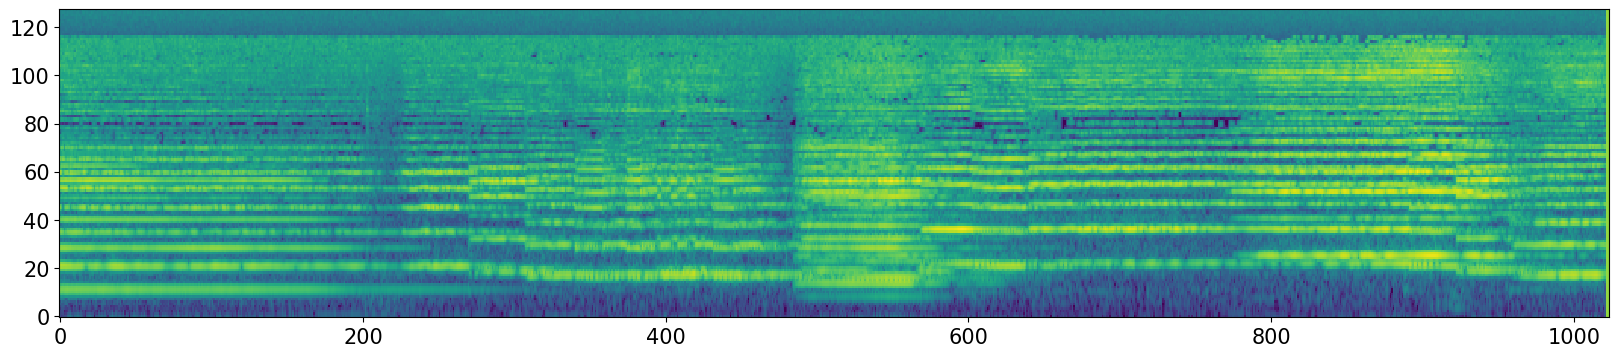

In [ ]:
fbank,_ = wav2fbank("violins/segment_10.wav")
#fbank,_ = wav2fbank("drums/combined_0.wav")

# move target to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fbank = fbank.to(device)

fbank_norm = norm_fbank(fbank)
display_fbank(fbank.cpu())

In [ ]:
input_tdim = 1024  # fine-tuning data length can be different with pretraining data length
ast_mdl = ASTModel(label_dim=527,
             fshape=16, tshape=16, fstride=16, tstride=16,
             input_fdim=128, input_tdim=input_tdim, model_size='base',
             pretrain_stage=False, load_pretrained_mdl_path='SSAST-Base-Patch-400.pth')

now load a SSL pretrained models from SSAST-Base-Patch-400.pth
pretraining patch split stride: frequency=16, time=16
pretraining patch shape: frequency=16, time=16
pretraining patch array dimension: frequency=8, time=64
pretraining number of patches=512
fine-tuning patch split stride: frequncey=16, time=16
fine-tuning number of patches=512


# RELAX

In [ ]:
import torch
import torchvision
import torch.nn as nn
import tqdm.notebook as tqdm
import torch.nn.functional as F
import matplotlib.gridspec as gridspec

from PIL import Image
from matplotlib import pyplot as plt
from torchvision.transforms.functional import pil_to_tensor
from torchvision.transforms import ToTensor, Normalize, Resize

In [ ]:
def imsc(img, *args, quiet=False, lim=None, interpolation='lanczos', **kwargs):
    if isinstance(img, Image.Image):
        img = pil_to_tensor(img)
    handle = None
    with torch.no_grad():
        if not lim:
            lim = [img.min(), img.max()]
        img = img - lim[0]  # also makes a copy
        img.mul_(1 / (lim[1] - lim[0]))
        img = torch.clamp(img, min=0, max=1)
        if not quiet:
            bitmap = img.expand(3,
                                *img.shape[1:]).permute(1, 2, 0).cpu().numpy()
    return bitmap


In [ ]:
def MaskGenerator(iterations, inp_width,inp_height, num_cells=7, mask_bs=2, p=0.5, nsd=2, dev='cpu'):
    for iteration in range(iterations):

        pad_size = (num_cells // 2, num_cells // 2, num_cells // 2, num_cells // 2)
        grid = (torch.rand(mask_bs, 1, *((num_cells,) * nsd), device=dev) < p).float()

        grid_up = F.interpolate(grid, size=(inp_width,inp_height), mode='bilinear', align_corners=False)
        grid_up = F.pad(grid_up, pad_size, mode='reflect')

        shift_x = torch.randint(0, num_cells, (mask_bs,), device=dev)
        shift_y = torch.randint(0, num_cells, (mask_bs,), device=dev)

        masks = torch.empty((mask_bs, 1, inp_width, inp_height), device=dev)

        for i in range(mask_bs):
            masks[i] = grid_up[i, :,
                               shift_x[i]:shift_x[i] + inp_width,
                               shift_y[i]:shift_y[i] + inp_height]

        yield masks


In [ ]:
def batched_yield(masks, batch_size=100):
    n_combinations = masks.size(0)
    for start_idx in range(0, n_combinations, batch_size):
        end_idx = min(start_idx + batch_size, n_combinations)
        yield masks[start_idx:end_idx], end_idx-start_idx

def MaskFrequencyGenerator(inp_width,inp_height, num_bands=[1,2,3],p=[0.1,0.2,0.3], dev='cpu'):
    """num_bands is a list containting numbers indicating how many bands of frequency should be masked at a time
    p are the masking percentage of the frequencies for each number of bands, the band sizes adjust to conform with this percentage.
    """
    from itertools import combinations
    import math

    for masking_pct,num_band in zip(p,num_bands):
      band_height = int((inp_height * masking_pct) // num_band) # how tall a band should be so that the bands cover masking_pct of the frequencies
      num_position = math.ceil(inp_height / band_height) # how many potential positions can a band be in
      n_combinations = special.binom(num_position, num_band).astype(int) # how many unique ways can we mask the frequencies given the parameters?
      masks = torch.ones(n_combinations,1,inp_width,inp_height, device=dev)
      for i,combo in enumerate(combinations(range(num_position), num_band)):  # loop through combinations
        combo = np.asarray(combo)
        combo = (combo*band_height).astype(int) # find starting indexes of band
        for idx in combo:
          masks[i,0,:,idx:min(idx+band_height,inp_height)] = 0
      yield from batched_yield(masks)
def MaskTimeGenerator(inp_width,inp_height, num_bands=[1,2,3],p=[0.1,0.2,0.3], dev='cpu'):
    """num_bands is a list containting numbers indicating how many bands of frequency should be masked at a time
    p are the masking percentage of the frequencies for each number of bands, the band sizes adjust to conform with this percentage.
    """
    from itertools import combinations
    import math

    for masking_pct,num_band in zip(p,num_bands):
      band_width = int((inp_width * masking_pct) // num_band) # how tall a band should be so that the bands cover masking_pct of the frequencies
      num_position = math.ceil(inp_width / band_width) # how many potential positions can a band be in
      n_combinations = special.binom(num_position, num_band).astype(int) # how many unique ways can we mask the frequencies given the parameters?
      masks = torch.ones(n_combinations,1,inp_width,inp_height, device=dev)
      for i,combo in enumerate(combinations(range(num_position), num_band)):  # loop through combinations
        combo = np.asarray(combo)
        combo = (combo*band_width).astype(int) # find starting indexes of band
        for idx in combo:
          masks[i,0,idx:min(idx+band_width,inp_width),:] = 0
      yield from batched_yield(masks)

def MaskTimeFrequencyGenerator(inp_width,inp_height, num_bands_time=[1,2,3],p_time=[0.1,0.2,0.3],num_bands_freq=[1,2,3],p_freq=[0.1,0.2,0.3], dev='cpu'):
  yield from MaskTimeGenerator(inp_width,inp_height, num_bands_time,p_time, dev=dev)
  yield from MaskFrequencyGenerator(inp_width,inp_height, num_bands_freq,p_freq, dev=dev)

In [ ]:
def prepare_for_plot(bank, minmin=None, maxmax=None):
    return bank.cpu().T.numpy()

In [ ]:
torch.cuda.empty_cache() # use this to free GPU memory

# Random masking

In [ ]:
torch.manual_seed(100)

pdist = nn.CosineSimilarity(dim=1)

model_name_list = ['SSAST']
model_list = [ast_mdl]

mask_bs, inp_width, inp_height, num_batches = 100,1024,128,80

x = fbank.unsqueeze(0)

device = 'cuda'

with torch.no_grad():
  for model_loader, model_name in zip(model_list, model_name_list):

      model = model_loader
      h_star = model(x,task='ft_avgtok')
      h_star = h_star.expand(mask_bs, -1)
      #h_star = torch.mean(h_star,dim=0)


      saliency = torch.zeros((inp_width, inp_height), device=device)
      saliency_var = torch.zeros((inp_width, inp_height), device=device)

      for mask_idx, mask in enumerate(tqdm.tqdm(MaskGenerator(
                                                      num_batches, inp_width,inp_height, mask_bs=mask_bs,dev=device),
                                                      total=num_batches,
                                                      desc=f"Compute {model_name} importance")):

            #x_mask = x * mask # FIX: this sets values to zeros, but that doesn't make sens
            x_mask = x.min() + mask*(x-x.min()) # this may be the fix??
            x_mask = x_mask.squeeze(1)
            out = model(x_mask, task='ft_avgtok')

            out = pdist(h_star, out)[:, None, None, None]

            saliency += torch.mean(out * mask, dim=(0, 1))

      saliency /= (num_batches*0.5)

      for mask_idx, mask in enumerate(tqdm.tqdm(MaskGenerator(num_batches, inp_width,inp_height, mask_bs=mask_bs,dev=device),
                              total=num_batches, desc=f"Compute {model_name} uncertainty")):

          #x_mask = x * mask
          x_mask = x.min() + mask*(x-x.min()) # this may be the fix??
          x_mask = x_mask.squeeze(1)

          out = model(x_mask, task='ft_avgtok')

          out = pdist(h_star, out)[:, None, None, None]

          var = (out-saliency[None, None])**2
          var = torch.mean(var * mask, dim=(0, 1))

          saliency_var += var

      saliency_var /= ((num_batches-1)*0.5)

Compute SSAST importance:   0%|          | 0/80 [00:00<?, ?it/s]

Compute SSAST uncertainty:   0%|          | 0/80 [00:00<?, ?it/s]

# Time Masks

In [ ]:
torch.manual_seed(100)

pdist = nn.CosineSimilarity(dim=1)

model_name_list = ['SSAST']
model_list = [ast_mdl]



num_bands = [1,1,2,3]
p = [0.1,0.05,0.1,0.1]

num_bands_1 = [3,2,5]
p_1 = [0.2,0.3,0.4]
inp_width, inp_height = 1024,128

x = fbank.unsqueeze(0)

device = 'cuda'

with torch.no_grad():
  for model_loader, model_name in zip(model_list, model_name_list):

      model = model_loader
      h_star = model(x,task='ft_avgtok')

      saliency = torch.zeros((inp_width, inp_height), device=device)
      saliency_var = torch.zeros((inp_width, inp_height), device=device)

      total_masks_applied = []
      for mask_idx, (mask,batch_size) in enumerate(tqdm.tqdm(MaskTimeGenerator(inp_width,inp_height, num_bands=num_bands,p=p,dev=device),
                                                      total=1,
                                                      desc=f"Compute {model_name} importance")):
            h_star_expanded = h_star.expand(batch_size, -1)
            total_masks_applied.append(batch_size)
            #x_mask = x * mask # FIX: this sets values to zeros, but that doesn't make sens
            x_mask = x.min() + mask*(x-x.min()) # this may be the fix??
            x_mask = x_mask.squeeze(1)

            out = model(x_mask, task='ft_avgtok')

            out = pdist(h_star_expanded, out)[:, None, None, None]

            saliency += torch.sum(out * mask, dim=(0, 1))

      saliency /= np.sum(total_masks_applied)



      for mask_idx, (mask,batch_size) in enumerate(tqdm.tqdm(MaskTimeGenerator(inp_width,inp_height, num_bands=num_bands_1,p=p_1,dev=device),
                                                      total=1,
                                                      desc=f"Compute {model_name} uncertainty")):

          h_star_expanded = h_star.expand(batch_size, -1)
          #x_mask = x * mask # FIX: this sets values to zeros, but that doesn't make sens
          x_mask = x.min() + mask*(x-x.min()) # this may be the fix??
          x_mask = x_mask.squeeze(1)

          out = model(x_mask, task='ft_avgtok')

          out = pdist(h_star_expanded, out)[:, None, None, None]

          var = (out-saliency[None, None])**2
          var = torch.sum(var * mask, dim=(0, 1))

          saliency_var += var

      saliency_var /= np.sum(total_masks_applied)

print("DONE")
print("TOTAL NUMBER OF APPLIED MASKS: SUM(" + str(total_masks_applied) + ")=" + str(np.sum(total_masks_applied)))

Compute SSAST importance:   0%|          | 0/1 [00:00<?, ?it/s]

Compute SSAST uncertainty:   0%|          | 0/1 [00:00<?, ?it/s]

DONE
TOTAL NUMBER OF APPLIED MASKS: SUM([11, 21, 100, 100, 10, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 95])=4737


#Frequency masks

In [ ]:
torch.manual_seed(100)

pdist = nn.CosineSimilarity(dim=1)

model_name_list = ['SSAST']
model_list = [ast_mdl]
inp_width, inp_height = 1024,128

num_bands = [1,1,2,3]
p = [0.1,0.05,0.1,0.1]
num_bands_1 = [3,2,5]
p_1 = [0.2,0.3,0.4]

x = fbank.unsqueeze(0)

device = 'cuda'

with torch.no_grad():
  for model_loader, model_name in zip(model_list, model_name_list):

      model = model_loader
      h_star = model(x,task='ft_avgtok')


      saliency = torch.zeros((inp_width, inp_height), device=device)
      saliency_var = torch.zeros((inp_width, inp_height), device=device)

      total_masks_applied = []
      for mask_idx,  (mask,batch_size) in enumerate(tqdm.tqdm(MaskFrequencyGenerator(inp_width,inp_height, num_bands=num_bands,p=p,dev=device),
                                                      total=1,
                                                      desc=f"Compute {model_name} importance")):
            h_star_expanded = h_star.expand(batch_size, -1)
            total_masks_applied.append(batch_size)
            #x_mask = x * mask # FIX: this sets values to zeros, but that doesn't make sens
            x_mask = x.min() + mask*(x-x.min()) # this may be the fix??
            x_mask = x_mask.squeeze(1)

            out = model(x_mask, task='ft_avgtok')

            out = pdist(h_star_expanded, out)[:, None, None, None]

            saliency += torch.sum(out * mask, dim=(0, 1))

      saliency /= np.sum(total_masks_applied)



      for mask_idx,  (mask,batch_size) in enumerate(tqdm.tqdm(MaskFrequencyGenerator(inp_width,inp_height, num_bands=num_bands_1,p=p_1,dev=device),
                                                      total=1,
                                                      desc=f"Compute {model_name} uncertainty")):

          h_star_expanded = h_star.expand(batch_size, -1)
          #x_mask = x * mask # FIX: this sets values to zeros, but that doesn't make sens
          x_mask = x.min() + mask*(x-x.min()) # this may be the fix??
          x_mask = x_mask.squeeze(1)

          out = model(x_mask, task='ft_avgtok')

          out = pdist(h_star_expanded, out)[:, None, None, None]

          var = (out-saliency[None, None])**2
          var = torch.sum(var * mask, dim=(0, 1))

          saliency_var += var

      saliency_var /= np.sum(total_masks_applied)

print("DONE")
print("TOTAL NUMBER OF APPLIED MASKS: SUM(" + str(total_masks_applied) + ")=" + str(np.sum(total_masks_applied)))

Compute SSAST importance:   0%|          | 0/1 [00:00<?, ?it/s]

Compute SSAST uncertainty:   0%|          | 0/1 [00:00<?, ?it/s]

DONE
TOTAL NUMBER OF APPLIED MASKS: SUM([11, 22, 100, 100, 31, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 60])=5224


# Time + Frequency

In [ ]:
torch.manual_seed(100)

pdist = nn.CosineSimilarity(dim=1)

model_name_list = ['SSAST']
model_list = [ast_mdl]
inp_width, inp_height = 1024,128

num_bands_time = [1,1,2,3]
p_time = [0.1,0.05,0.1,0.1]
num_bands_frequency = [1,1,2,3]
p_frequency = [0.1,0.05,0.1,0.1]
num_bands_time_1 = [3,2,5]
p_time_1 = [0.2,0.3,0.4]
num_bands_frequency_1 = [3,2,5]
p_frequency_1 = [0.2,0.3,0.4]

x = fbank.unsqueeze(0)

device = 'cuda'

with torch.no_grad():
  for model_loader, model_name in zip(model_list, model_name_list):

      model = model_loader
      h_star = model(x,task='ft_avgtok')


      saliency = torch.zeros((inp_width, inp_height), device=device)
      saliency_var = torch.zeros((inp_width, inp_height), device=device)

      total_masks_applied = []
      for mask_idx, (mask,batch_size) in enumerate(tqdm.tqdm(MaskTimeFrequencyGenerator(inp_width,inp_height,
                                                                                            num_bands_time=num_bands_time,p_time=p_time,
                                                                                            num_bands_freq=num_bands_frequency,p_freq=p_frequency,dev=device),
                                                      total=1,
                                                      desc=f"Compute {model_name} importance")):
            h_star_expanded = h_star.expand(batch_size, -1)
            total_masks_applied.append(batch_size)
            #x_mask = x * mask # FIX: this sets values to zeros, but that doesn't make sens
            x_mask = x.min() + mask*(x-x.min()) # this may be the fix??
            x_mask = x_mask.squeeze(1)

            out = model(x_mask, task='ft_avgtok')

            out = pdist(h_star_expanded, out)[:, None, None, None]

            saliency += torch.sum(out * mask, dim=(0, 1))
      saliency /= np.sum(total_masks_applied)

      for mask_idx, (mask,batch_size) in enumerate(tqdm.tqdm(MaskTimeFrequencyGenerator(inp_width,inp_height,
                                                                                            num_bands_time=num_bands_time_1,p_time=p_time_1,
                                                                                            num_bands_freq=num_bands_frequency_1,p_freq=p_frequency_1,dev=device),
                                                      total=1,
                                                      desc=f"Compute {model_name} importance")):

          h_star_expanded = h_star.expand(batch_size, -1)
          #x_mask = x * mask # FIX: this sets values to zeros, but that doesn't make sens
          x_mask = x.min() + mask*(x-x.min()) # this may be the fix??
          x_mask = x_mask.squeeze(1)

          out = model(x_mask, task='ft_avgtok')

          out = pdist(h_star_expanded, out)[:, None, None, None]

          var = (out-saliency[None, None])**2
          var = torch.sum(var * mask, dim=(0, 1))

          saliency_var += var

      saliency_var /= np.sum(total_masks_applied)

print("DONE")
print("TOTAL NUMBER OF APPLIED MASKS: SUM(" + str(total_masks_applied) + ")=" + str(np.sum(total_masks_applied)))

Compute SSAST importance:   0%|          | 0/1 [00:00<?, ?it/s]

Compute SSAST importance:   0%|          | 0/1 [00:00<?, ?it/s]

DONE
TOTAL NUMBER OF APPLIED MASKS: SUM([11, 21, 100, 100, 10, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 95, 11, 22, 100, 100, 31, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 60])=9961


# Display Explanation

In [ ]:
saliency_norm = (saliency-saliency.min())/(saliency.max()-saliency.min())
saliency_var_norm =(saliency_var-saliency_var.min())/(saliency_var.max()-saliency_var.min())

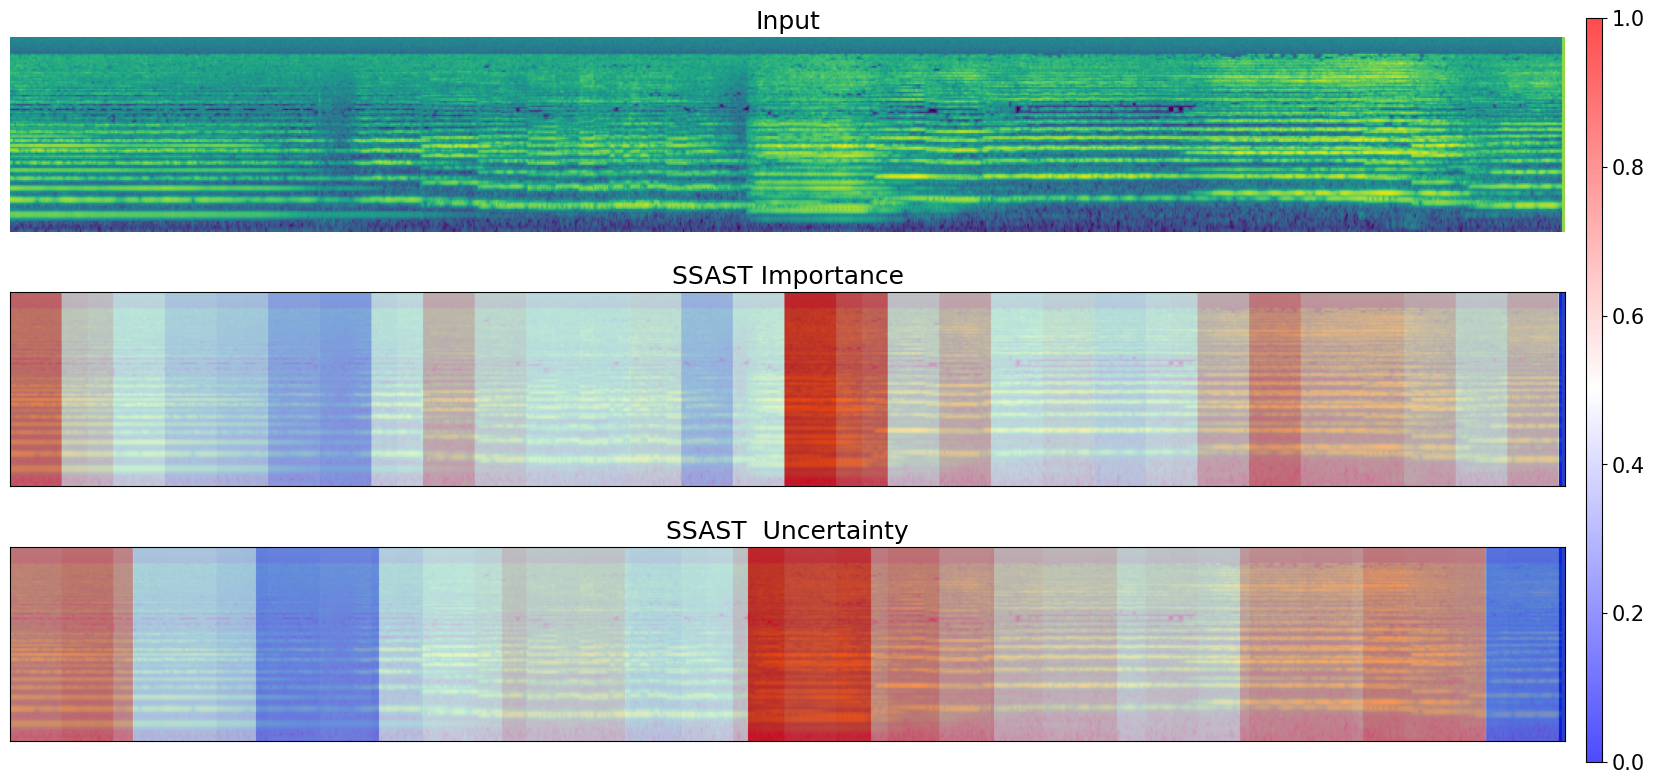

In [ ]:
# Create a figure and gridspec
fig = plt.figure(1, figsize=(16, 8))
gs = gridspec.GridSpec(3, 1)  # Adjusted to 3 rows and 1 column
font_size_colorbar = 15
font_size_titles = 18
plt.rcParams.update({'font.size': font_size_colorbar})

# Plotting the input
ax1a = plt.subplot(gs[0])
ax1a.imshow(prepare_for_plot(x[0]))
ax1a.axis('off')
ax1a.set_title('Input', fontsize=font_size_titles)
ax1a.invert_yaxis()

# Plotting importance for SSAST
ax2a = plt.subplot(gs[1])
ax2a.imshow(prepare_for_plot(x[0]))
im = ax2a.imshow(prepare_for_plot(saliency_norm.cpu()), alpha=0.7, cmap='bwr')
ax2a.set_xticks([])
ax2a.set_yticks([])
ax2a.set_title('SSAST Importance', fontsize=font_size_titles)
ax2a.invert_yaxis()


# Plotting uncertainty for SSAST
ax3a = plt.subplot(gs[2])
ax3a.imshow(prepare_for_plot(x[0]))
ax3a.imshow(prepare_for_plot(saliency_var_norm.cpu()), alpha=0.7, cmap='bwr')#
ax3a.set_xticks([])
ax3a.set_yticks([])
ax3a.set_title('SSAST  Uncertainty',  fontsize=font_size_titles)
ax3a.invert_yaxis()

# Adjust layout
plt.tight_layout()

# Add colorbar
cbar_ax = fig.add_axes([0.999, 0.025, 0.01, 0.93])
cbar = fig.colorbar(im, cax=cbar_ax)

# Show the plot
plt.show()

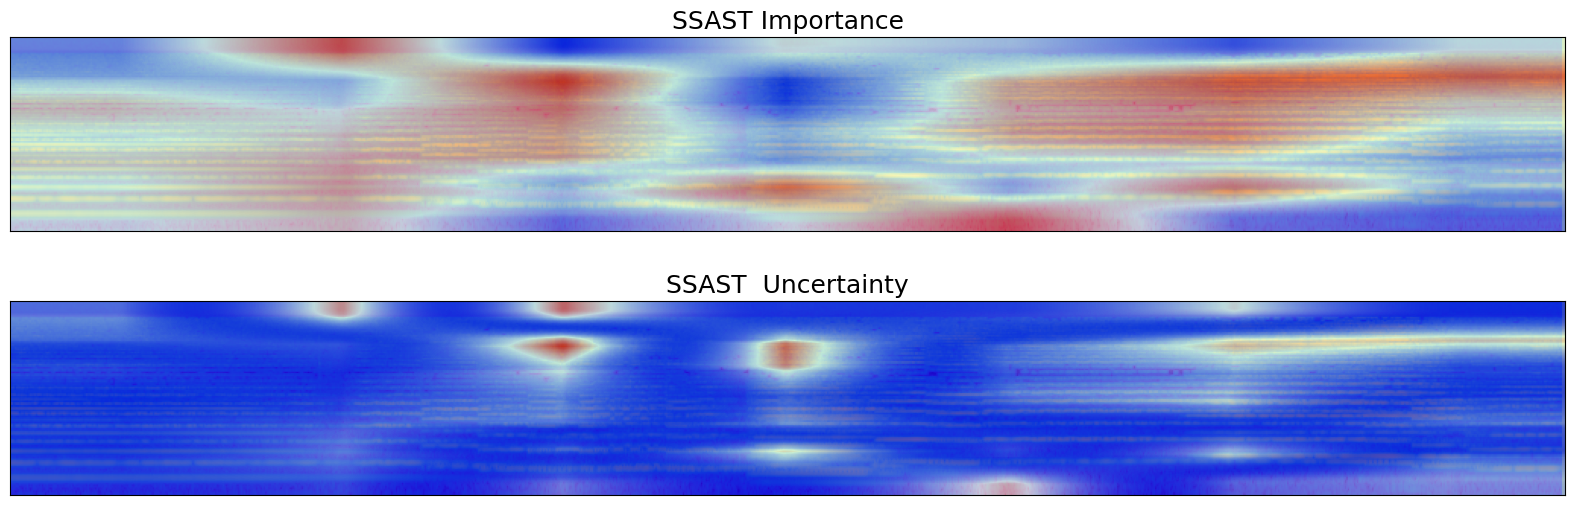

In [ ]:
# Create a figure and gridspec
fig = plt.figure(1, figsize=(16, 8))
gs = gridspec.GridSpec(3, 1)  # Adjusted to 3 rows and 1 column
font_size_colorbar = 15
font_size_titles = 18
plt.rcParams.update({'font.size': font_size_colorbar})

# Plotting importance for SSAST
ax2a = plt.subplot(gs[1])
ax2a.imshow(prepare_for_plot(x[0]))
im = ax2a.imshow(prepare_for_plot(saliency_norm.cpu()), alpha=0.7, cmap='bwr')
ax2a.set_xticks([])
ax2a.set_yticks([])
ax2a.set_title('SSAST Importance', fontsize=font_size_titles)
ax2a.invert_yaxis()


# Plotting uncertainty for SSAST
ax3a = plt.subplot(gs[2])
ax3a.imshow(prepare_for_plot(x[0]))
ax3a.imshow(prepare_for_plot(saliency_var_norm.cpu()), alpha=0.7, cmap='bwr')#
ax3a.set_xticks([])
ax3a.set_yticks([])
ax3a.set_title('SSAST  Uncertainty',  fontsize=font_size_titles)
ax3a.invert_yaxis()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()